In [219]:
import copy

import cv2
import matplotlib.pyplot as plt
import numpy as np

# some helper function

def minus_within(num1, num2, min_):
    result = num1 - num2
    if result >= min_:
        return result
    else:
        return min_


def plus_within(num1, num2, max_):
    result = num1 + num2
    if result <= max_:
        return result
    else:
        return max_


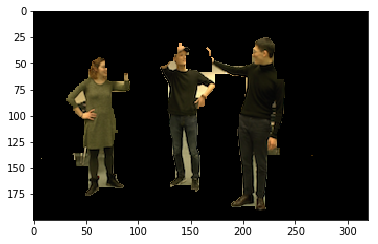

In [220]:
after_sub = cv2.imread("after_sub_3.png",1)
plt.imshow(after_sub)
plt.show()

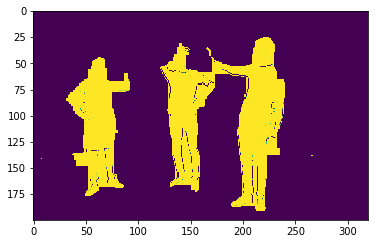

In [221]:
mask = cv2.threshold(after_sub, 1, 255, cv2.THRESH_BINARY)[1]
binary_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
plt.imshow(binary_mask)
plt.show()

In [222]:
img = binary_mask
min_height = 90
max_height = 180

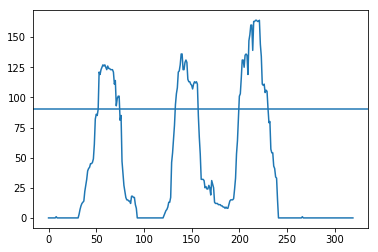

In [223]:
#
# 1: get each line's height
#

# vertical line
# amount of non zero pixels in each vertical_line
nonzero_height_in_line_list = np.count_nonzero(img, axis=0)
plt.plot(nonzero_height_in_line_list)
plt.axhline(90)
plt.show()

# Intersections are left and right boundries of human bodies

[52, 133, 200]
[75, 157, 231]


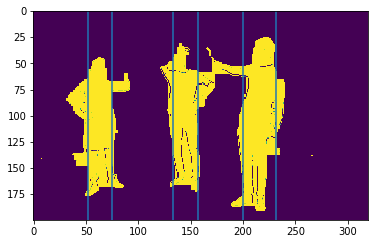

In [234]:
#
# 2: get positions of lines with enough height
#

list_of_left_side_of_body = []
list_of_right_side_of_body = []


width = len(nonzero_height_in_line_list)
for index in range(0, width):
    length = nonzero_height_in_line_list[index]

    length_before = nonzero_height_in_line_list[minus_within(index, 1, 0)]
    curve_around = [
        nonzero_height_in_line_list[idx]
        for idx in range(
            minus_within(index, 10, 0), plus_within(index, 10, width))
    ]

    # fix the cure to a second degree polynomio
    poly = np.poly1d(np.polyfit(range(len(curve_around)), curve_around, 2))
    deriv = poly.deriv()
    # direction > 0 means height increasing, opposite means decreasing
    direction = deriv(len(curve_around) / 2)

    if length < max_height:
        if length_before <= min_height and length >= min_height and direction > 0:
            # increasing height
            list_of_left_side_of_body.append(index)
        elif length_before >= min_height and length <= min_height and direction < 0:
            # decreasing height
            list_of_right_side_of_body.append(index)
            

    # remove positions that are too close to each other
    # between two left postion or two right position,
    # there should be at least 50 pixels
    PADDING = 5
    tmp_list = copy.copy(list_of_left_side_of_body)
    list_of_left_side_of_body = []
    for index in range(0, len(tmp_list)):
        if not (index >= 1 and
                (tmp_list[index] - tmp_list[index - 1]) < 50):
            # make the range wider between left and right
            # so more body can be coverd
            list_of_left_side_of_body.append(tmp_list[index])

    tmp_list = copy.copy(list_of_right_side_of_body)
    list_of_right_side_of_body = []
    for index in range(0, len(tmp_list)):
        if not (index >= 1 and
                (tmp_list[index] - tmp_list[index - 1]) < 50):
            # make the range wider between left and right
            # so more body can be coverd
            list_of_right_side_of_body.append(tmp_list[index])

# make sure padding does exceed frame width
for index in range(0, len(list_of_left_side_of_body)):
    if list_of_left_side_of_body[index] < 0:
        list_of_left_side_of_body[index] = 0
for index in range(0, len(list_of_right_side_of_body)):
    if list_of_right_side_of_body[index] > width - 1:
        list_of_right_side_of_body[index] = width -1

print(list_of_left_side_of_body)
print(list_of_right_side_of_body)

for xcoord in list(list_of_left_side_of_body) + list(list_of_right_side_of_body):
    plt.axvline(xcoord)
plt.imshow(img)
plt.show()

In [238]:
#
# 3: pack each two lines into a tuple that represent a body
#

# body_sides is a list of tuples of left and right position of each body
if len(list_of_left_side_of_body) < len(list_of_right_side_of_body):
    body_sides = zip([0, *list_of_left_side_of_body],
                     list_of_right_side_of_body)
elif len(list_of_left_side_of_body) > len(list_of_right_side_of_body):
    body_sides = zip(list_of_left_side_of_body,
                     [*list_of_right_side_of_body, width-1])
else:
    body_sides = zip(list_of_left_side_of_body, list_of_right_side_of_body)

# so we can use it many times with out exhausting it (as iterator)
body_sides = list(body_sides)

print(body_sides)

[(52, 75), (133, 157), (200, 231)]


In [240]:
#
# 4: find upper left and down right of each body
#

body_coordinate_list = []

for left, right in body_sides:
    # guard against situations like [8,8]
    if right - left < 3:
        break

    # for each body
    xlist = []
    ylist = []
    # find all the coordinates of non zero pixels
    for x in range(left, right):
        # only colomns between left and right boundries
        for y in range(0, img.shape[0]):
            if img[y, x] > 0:
                xlist.append(x)
                ylist.append(y)

    xmin = min(xlist)
    xmax = max(xlist)
    ymin = min(ylist)
    ymax = max(ylist)

    body_coordinate_list.append(((xmin, ymin), (xmax, ymax)))

print(body_coordinate_list)

[((52, 45), (74, 176)), ((133, 31), (156, 172)), ((200, 26), (230, 190))]


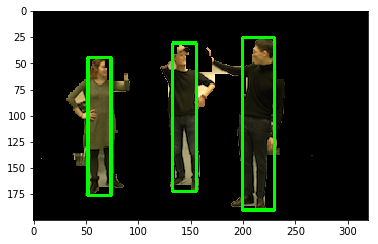

In [241]:
# draw boxes around image
copy_img = copy.copy(after_sub)
for pt1, pt2 in body_coordinate_list:
    cv2.rectangle(copy_img, pt1, pt2, (0, 255, 0), 2)

plt.imshow(copy_img)
plt.show()

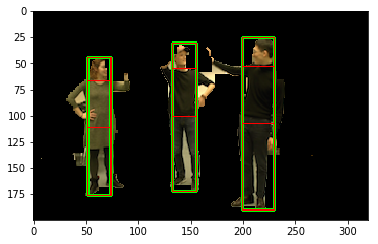

In [242]:
# separate head, body and leg
all_component_list = []
for ((xmin, ymin), (xmax, ymax)) in body_coordinate_list:
    head_xmin, head_ymin = xmin, ymin
    head_xmax, head_ymax = xmax, round((ymax-ymin) / 6) + ymin
    
    body_xmin, body_ymin = xmin, head_ymax
    body_xmax, body_ymax = xmax, round((ymax-ymin) / 2) + ymin
    
    leg_xmin, leg_ymin = xmin, body_ymax
    leg_xmax, leg_ymax = xmax, ymax
    
    component_list = [((head_xmin, head_ymin), (head_xmax, head_ymax)),
                    ((body_xmin, body_ymin), (body_xmax, body_ymax)),
                    ((leg_xmin, leg_ymin), (leg_xmax, leg_ymax))]
    
    for pt1, pt2 in component_list:
        cv2.rectangle(copy_img, pt1, pt2, (255, 0, 0), 1)
    
    all_component_list.append(component_list)

plt.imshow(copy_img)
plt.show()